In [13]:
from pathlib import Path
from Tensorlib import tensor
from Transformerlib import GPT
import numpy as np
from matplotlib import pyplot as plt

dataloc = Path("./Data/input.txt")
with open (dataloc, 'r', encoding='utf-8') as datafile:
    data = datafile.read()

vocab = sorted(set(data.split()))
print(f"Vocabulary Size Word Level: {len(vocab)}")
print(f"Vocabulary: {vocab}")

vocab = sorted(set(data))
print(f"Vocabulary Size Char Level: {len(vocab)}")
print(f"Vocabulary: {vocab}")

Vocabulary Size Word Level: 25670
Vocabulary: ['&C:', '&c.', "'", "'?", "'A", "'Alas,", "'Alas,'", "'Alla", "'An", "'Ay", "'Ay,", "'Ay,'", "'Ay.'", "'Be", "'Beseech", "'Bless", "'Bove", "'Brutus!'", "'By", "'Charge", "'Charge!", "'Citizens!'", "'Clarence", "'Come", "'Come,", "'Commend", "'Con", "'Content'", "'Coriolanus!'", "'Courage!'", "'Courage,", "'Cucullus", "'Dear", "'Death.'", "'Deny", "'Do", "'Fair", "'Faith,", "'Farewell:'", "'Fine;'", "'Fore", "'Forgive", "'Frets,", "'G'", "'Gainst", "'Go", "'God", "'Good", "'Have", "'He", "'Heart's", "'Hell", "'Hic", "'Hold,", "'I", "'I'", "'I';", "'I'll", "'I,'", "'I.'", "'Is", "'It", "'Jack,", "'Jesu", "'King", "'Lo,", "'Madam,'", "'Margaret.'", "'My", "'Now", "'O", "'O,", "'Pardon'", "'Patricians!'", "'Peace,", "'Priami,'", "'Proud,'", "'Redime", "'Remember", "'Retire,'", "'Rise;'", "'Romeo", "'Saint", "'Save", "'Scape", "'Shall'!", "'She", "'Sicilia", "'Sicinius!'", "'Sigeia", "'Signior", "'Simois,'", "'Sir,", "'Sirrah,", "'Small", "'Sta

Down below is the training loop. The methods are explained with comments in the lib file.

In [14]:
gpt = GPT(
    vocab_size=65,
    context_length=64,
    emb_dim=64,
    num_heads=16,
    num_layers=4
)

loss_list=gpt.train(
        data = data,
        tokenization_mode='char',
        epochs=2,
        learning_rate=0.00001, 
        batch=4)

epochs, losses = zip(*loss_list)

plt.plot(epochs, losses)
plt.show()

Epoch: 0 | Loss: Tensor Values = 4.181527137756348
Epoch: 0 | Loss: Tensor Values = 4.18640661239624
Epoch: 0 | Loss: Tensor Values = 4.189790725708008
Epoch: 0 | Loss: Tensor Values = 4.190375328063965
Epoch: 0 | Loss: Tensor Values = 4.1865057945251465
Epoch: 0 | Loss: Tensor Values = 4.186437606811523
Epoch: 0 | Loss: Tensor Values = 4.177972793579102
Epoch: 0 | Loss: Tensor Values = 4.18476676940918
Epoch: 0 | Loss: Tensor Values = 4.179920196533203
Epoch: 0 | Loss: Tensor Values = 4.181307792663574
Epoch: 0 | Loss: Tensor Values = 4.1705708503723145
Epoch: 0 | Loss: Tensor Values = 4.179823875427246
Epoch: 0 | Loss: Tensor Values = 4.172397613525391
Epoch: 0 | Loss: Tensor Values = 4.17537784576416
Epoch: 0 | Loss: Tensor Values = 4.156506538391113
Epoch: 0 | Loss: Tensor Values = 4.148584365844727
Epoch: 0 | Loss: Tensor Values = 4.171679496765137
Epoch: 0 | Loss: Tensor Values = 4.144424915313721
Epoch: 0 | Loss: Tensor Values = 4.170422554016113
Epoch: 0 | Loss: Tensor Values =

KeyboardInterrupt: 

This is for manually saving the current model.

In [4]:
gpt.save_model("Shakespearean_best.npz")

Model saved to Shakespearean_best.npz


This is to load model from specified .npz file.

In [4]:
gpt = GPT(
    vocab_size=65,
    context_length=24,
    emb_dim=128,
    num_heads=16,
    num_layers=1
)

gpt.load_model(data=data, filename="Shakespearean_model_3003.npz")

This is where we generate the output of our model. The first argument is the start_token, sort of like the prompt we give to ChatGPT.

In [4]:
print(gpt.generate('King', 300, temperature=1))

Kinged's us: we Falt heart's
the crome us, there unt on
Thene grosies this any solmer Hasly
And destfore elther of seent, sirp,
Is leech's and your noth requach,
make welcid a withoused peeritle and hing.

YARD-S:
For Lords, I me humboy tould.

FRUCHIO:
Lest's the our you.

DUCIO:
How lomes.
Jet ere ese


Okay. The model did learn. It learnt words, some grammar, the poetic structure and the some sentence structure. But it failed to capture the flow, and meaning. We can train longer, increase context size, deepen the layers etc. To keep this repo pure and numpy only, the tests aren't here, but pytorch was 3x faster on CPU due to low level memory and performance optimisations in C++. However, the training time was still extremely slow and it was clear that getting a low enough error and proper generation is extremely tedious on CPU, despite the framework we use.

### Visualization 
Let's try to visualise the Query, Key correlation table to understand how our model decipher's relationships. For that, we have to add a flag in our attention class to return the Query @ Key.T matrix before softmaxing. 

dataSegment: 
First Citizen:
Before we

dataSegToVis: 
First Citizen:
Before w


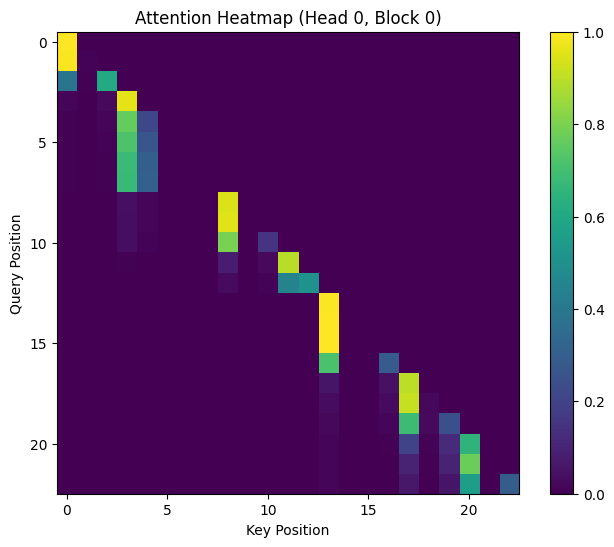

In [12]:
context_length = 24

dataSegment = data[:context_length]

#DataSegment to visualise.
dataSegToVis = data[:context_length-1]

print(f"dataSegment: \n{dataSegment}\n")
print(f"dataSegToVis: \n{dataSegToVis}")

#Encoding
input_tokens = tensor(gpt.tokenizer.encode(dataSegToVis)) #We are dropping the last character to see what the model predicts.

#Embedding the data
word_embeddings = gpt.token_emb(input_tokens.reshape(shape=(1, -1))) #Since the call expects batch dimension too
pos_embeddings = gpt.pos_emb(word_embeddings)
x = word_embeddings + pos_embeddings

# Get attention scores from the first block and first head
attn_scores, output = gpt.blocks[0].msa(x, returnAttention=True) # attn_scores shape: (batch, num_heads, tokens, tokens)

scores = attn_scores[0, 0]  # First batch, first head # attn_scores shape: (tokens, tokens) i.e Query vs Keys

plt.figure(figsize=(8, 6))
plt.imshow(scores, cmap='viridis')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Attention Heatmap (Head 0, Block 0)')
plt.colorbar()
plt.show()

#### Insights:

1. Casual masking is working correctly! All the upper traingular elements have 0 scores.

2. The last character 'w'(at 22nd position or the 23rd character, since we dropped the last word for prediction), is attending the most to the character at 20th position, which is the 21st character 'e' in the sequence. So, the model would have most likely returned e as it's prediction, which is accurate!

3. But why did it really happen ? The Query from 'w' is essentially asking: "I am the start of a new word. What was the last meaningful thing that happened?" The Key from 'e' answers: "I am the end of the previous word."

4. But this was our personal assumption about query vs key relationship causing the high attention. We cannot be 100% sure about this but we can analyse if this pattern repeats by taking more samples and plotting similar heatmap. 

5. We can also notice how the query of 'w' was completely missed by the character before it ' '. This tells us the model knows 'being followed by space' does not provide any meaningful information to generate the next character. 

These are some tests created with AI for gradient flow validation.


In [ ]:
def numerical_gradient(f, x, eps=1e-5):
    grad = np.zeros_like(x.matrix)
    it = np.nditer(x.matrix, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        orig = x.matrix[idx]
        x.matrix[idx] = orig + eps
        fx1 = f(x).matrix.item()
        x.matrix[idx] = orig - eps
        fx2 = f(x).matrix.item()
        x.matrix[idx] = orig  # restore
        grad[idx] = (fx1 - fx2) / (2 * eps)
        it.iternext()
    return grad

def compare_grads(label, f, x):
    x.zero_grad()
    loss = f(x)
    loss.backward()
    analytical = x.grad.copy()
    numerical = numerical_gradient(f, x)
    abs_diff = np.abs(analytical - numerical)
    print(f"{label} - max abs diff: {abs_diff.max()}, mean abs diff: {abs_diff.mean()}, sum abs diff: {abs_diff.sum()}")
    print(f"Analytical grad:\n{analytical}\nNumerical grad:\n{numerical}\nAbs diff:\n{abs_diff}")

# 1. Mean over all elements
x = tensor(np.random.randn(2, 3, 4))
compare_grads("mean_all", lambda x: x.mean(), x)

# 2. Mean over axis 0 (batch)
x = tensor(np.random.randn(2, 3, 4))
compare_grads("mean_axis0", lambda x: x.mean(axis=0).sum(), x)

# 3. Mean over axis 1 (tokens)
x = tensor(np.random.randn(2, 3, 4))
compare_grads("mean_axis1", lambda x: x.mean(axis=1).sum(), x)

# 4. Mean over axis 2 (dims)
x = tensor(np.random.randn(2, 3, 4))
compare_grads("mean_axis2", lambda x: x.mean(axis=2).sum(), x)

# 5. Mean after sum (simulate loss scaling)
x = tensor(np.random.randn(2, 3, 4))
compare_grads("sum_then_mean", lambda x: x.sum().mean(), x)

# 6. Mean after advanced indexing (as in cross-entropy)
batch, tokens, dims = 2, 3, 4
x = tensor(np.random.randn(batch, tokens, dims))
targets = np.random.randint(0, dims, size=(batch, tokens))
batch_idx = np.arange(batch, dtype=np.intp).reshape(-1,1)
token_idx = np.arange(tokens, dtype=np.intp).reshape(1,-1)
def f_index(x):
    log_probs = x.log_softmax()
    nll = -1 * log_probs[batch_idx, token_idx, targets]
    return nll.mean()
compare_grads("indexing+mean", f_index, x)

# 7. Full cross-entropy loss (as in real training)
x = tensor(np.random.randn(batch, tokens, dims))
targets = np.random.randint(0, dims, size=(batch, tokens))
def f_ce(x):
    return GPT._cross_entropy_loss(x, targets)
compare_grads("full_cross_entropy", f_ce, x)

mean_all - max abs diff: 0.0015467007954915318, mean abs diff: 0.0009879072507222473, sum abs diff: 0.023709774017333936
Analytical grad:
[[[0.04166667 0.04166667 0.04166667 0.04166667]
  [0.04166667 0.04166667 0.04166667 0.04166667]
  [0.04166667 0.04166667 0.04166667 0.04166667]]

 [[0.04166667 0.04166667 0.04166667 0.04166667]
  [0.04166667 0.04166667 0.04166667 0.04166667]
  [0.04166667 0.04166667 0.04166667 0.04166667]]]
Numerical grad:
[[[0.04172325 0.04172325 0.04321337 0.04172325]
  [0.04321337 0.04321337 0.04321337 0.04321337]
  [0.04172325 0.04172325 0.04321337 0.04321337]]

 [[0.04321337 0.04172325 0.04321337 0.04321337]
  [0.04172325 0.04172325 0.04321337 0.04172325]
  [0.04321337 0.04321337 0.04321337 0.04321337]]]
Abs diff:
[[[5.65846761e-05 5.65846761e-05 1.54670080e-03 5.65846761e-05]
  [1.54670080e-03 1.54670080e-03 1.54670080e-03 1.54670080e-03]
  [5.65846761e-05 5.65846761e-05 1.54670080e-03 1.54670080e-03]]

 [[1.54670080e-03 5.65846761e-05 1.54670080e-03 1.54670080

In [ ]:
import random

# Hyperparameters for test
vocab_size = 20
context_length = 5
emb_dim = 8
num_heads = 2
batch_size = 3

# Dummy input (batch of token indices)
np.random.seed(42)
input_tokens_np = np.random.randint(0, vocab_size, size=(batch_size, context_length))
input_tokens = tensor(input_tokens_np)

# Instantiate model
gpt = GPT(vocab_size, context_length, emb_dim, num_heads)

# Forward pass
logits = gpt(input_tokens)
print("Logits shape:", logits.shape)
assert logits.shape == (batch_size, context_length, vocab_size), "Output shape mismatch"

# Dummy loss (sum)
loss = logits.sum()
loss.backward()

# Check all parameters for gradients
params = gpt.parameters()
param_names = [
    "block param " + str(i) for i in range(len(gpt.block.parameters()))
] + ["word_embeddings_table"] + [
    "ln_final param " + str(i) for i in range(len(gpt.ln_final.parameters()))
] + ["head_weight"]

for i, p in enumerate(params):
    grad = p.grad
    print(f"{param_names[i]} grad mean: {np.mean(grad) if grad is not None else None}")
    assert grad is not None, f"Parameter {param_names[i]} has no gradient!"
    assert np.any(grad != 0), f"Parameter {param_names[i]} gradient is all zeros!"

# Numerical gradient check for a few random indices in each parameter
eps = 1e-4
num_checks = 3

def loss_fn():
    logits = gpt(input_tokens)
    return logits.sum()

for i, p in enumerate(params):
    param_np = p.matrix
    shape = param_np.shape
    print(f"\nNumerical gradient check for {param_names[i]} (shape {shape}):")
    for _ in range(num_checks):
        idx = tuple(random.randint(0, s-1) for s in shape)
        orig = param_np[idx]
        param_np[idx] = orig + eps
        loss_plus = float(loss_fn().matrix.item())
        param_np[idx] = orig - eps
        loss_minus = float(loss_fn().matrix.item())
        param_np[idx] = orig  # restore
        num_grad = (loss_plus - loss_minus) / (2 * eps)
        analytical_grad = float(p.grad[idx])
        print(f"  Index {idx}: Numerical grad = {num_grad}, Analytical grad = {analytical_grad}, Abs diff = {abs(num_grad - analytical_grad)}")

In [ ]:
import tracemalloc
import psutil
import os
import numpy as np
import gc
import sys

def print_top_tensors(n=10):
    objs = gc.get_objects()
    tensor_objs = []
    for o in objs:
        try:
            if hasattr(o, 'matrix') and hasattr(o, '_operation'):
                tensor_objs.append(o)
        except Exception:
            continue
    tensor_objs = sorted(tensor_objs, key=lambda x: sys.getsizeof(getattr(x, 'matrix', b'')), reverse=True)
    print(f"Top {n} tensors still in memory:")
    for t in tensor_objs[:n]:
        try:
            print(f"  {t._operation} | shape: {getattr(t, 'shape', None)} | size: {getattr(t, 'matrix', None).nbytes/1024/1024:.2f} MB | id: {id(t)}")
        except Exception:
            continue

def clear_graph(t):
    # Recursively clear computation graph to break reference cycles
    visited = set()
    def _clear(node):
        if id(node) in visited:
            return
        visited.add(id(node))
        if hasattr(node, '_children'):
            for child in list(getattr(node, '_children', [])):
                _clear(child)
            node._children = set()
        if hasattr(node, '_backward'):
            node._backward = lambda: None
    _clear(t)

def print_mem(msg=""):
    process = psutil.Process(os.getpid())
    rss = process.memory_info().rss / 1024 / 1024  # Resident Set Size in MB
    current, peak = tracemalloc.get_traced_memory()
    print(f"{msg} | RSS: {rss:.2f} MB | Tracemalloc current: {current/1024/1024:.2f} MB | Peak: {peak/1024/1024:.2f} MB")

# Much larger hyperparameters for stress test
vocab_size = 10000
context_length = 128
emb_dim = 512
num_heads = 8
batch_size = 64
num_epochs = 3

np.random.seed(42)
input_tokens_np = np.random.randint(0, vocab_size, size=(batch_size, context_length))
input_tokens = tensor(input_tokens_np)
target_tokens_np = np.random.randint(0, vocab_size, size=(batch_size, context_length))
target_tokens = tensor(target_tokens_np)

gpt = GPT(vocab_size, context_length, emb_dim, num_heads)

def simple_loss(logits, targets):
    # Dummy loss: sum of logits at target indices (simulate cross-entropy)
    batch, tokens, vocab = logits.shape
    idx = (np.arange(batch)[:, None], np.arange(tokens)[None, :], targets.matrix)
    selected = logits.matrix[idx]
    return tensor(selected.sum())

def sgd_step(params, lr=1e-2):
    for p in params:
        if p.grad is not None:
            p.matrix -= lr * p.grad

tracemalloc.start()
for epoch in range(num_epochs):
    print_mem(f"Epoch {epoch+1} - Start")
    logits = gpt(input_tokens)
    print_mem(f"Epoch {epoch+1} - After forward")
    loss = simple_loss(logits, target_tokens)
    print_mem(f"Epoch {epoch+1} - After loss computation")
    loss.backward()
    print_mem(f"Epoch {epoch+1} - After backward")
    sgd_step(gpt.parameters())
    print_mem(f"Epoch {epoch+1} - After optimizer step")
    for p in gpt.parameters():
        p.grad = None

    clear_graph(loss)
    del logits, loss

    print_top_tensors(10)

    top_tensor = None
    for o in gc.get_objects():
        try:
            if hasattr(o, 'matrix') and hasattr(o, '_operation') and o._operation == '@' and getattr(o, 'shape', None) == (64, 128, 10000):
                top_tensor = o
                break
        except Exception:
            continue

    if top_tensor is not None:
        print(f"Referrers to top_tensor id {id(top_tensor)}:")
        for ref in gc.get_referrers(top_tensor):
            print(f"  Type: {type(ref)}, Repr: {repr(ref)[:200]}")
tracemalloc.stop()

In [ ]:
def numerical_grad_getitem(x_np, idx):
    grad = np.zeros_like(x_np)
    out_shape = x_np[idx].shape
    eps = 1e-5
    for out_idx in np.ndindex(*out_shape):
        # Find the corresponding input index
        # For advanced indexing, this is not always trivial, but for integer/fancy indexing it works
        x_pos = x_np.copy()
        x_neg = x_np.copy()
        # Use flat indexing for simplicity
        flat_idx = np.ravel_multi_index(out_idx, out_shape)
        # Find the input index that this output index maps to
        # This works for integer/fancy indexing, not for boolean masks
        try:
            input_idx = np.array(np.nonzero(np.isclose(x_np, x_np[idx][out_idx]))).T
            if input_idx.shape[0] > 0:
                input_idx = tuple(input_idx[0])
            else:
                continue
        except Exception:
            continue
        x_pos[input_idx] += eps
        x_neg[input_idx] -= eps
        out_pos = x_pos[idx]
        out_neg = x_neg[idx]
        grad[input_idx] += (out_pos[out_idx] - out_neg[out_idx]) / (2 * eps)
    return grad

# 1D integer array indexing
x_np = np.array([1.0, 2.0, 3.0, 4.0])
idx = [2, 1, 1, 0]
x = tensor(x_np)
out = x[idx]
print("1D getitem forward:", out.matrix)
expected = x_np[idx]
assert np.allclose(out.matrix, expected), "1D getitem forward failed"

# Backward
out_grad = np.array([1.0, 2.0, 3.0, 4.0])
x.zero_grad()
out._backward(out_grad)
expected_grad = np.zeros_like(x_np)
for i, ix in enumerate(idx):
    expected_grad[ix] += out_grad[i]
assert np.allclose(x.grad, expected_grad), "1D getitem backward failed"

# 2D integer array indexing
x_np = np.arange(12, dtype=np.float32).reshape(3, 4)
row_idx = np.array([0, 1, 2])
col_idx = np.array([1, 2, 3])
x = tensor(x_np)
out = x[row_idx, col_idx]
print("2D getitem forward:", out.matrix)
expected = x_np[row_idx, col_idx]
assert np.allclose(out.matrix, expected), "2D getitem forward failed"

# Backward
out_grad = np.array([1.0, 2.0, 3.0])
x.zero_grad()
out._backward(out_grad)
expected_grad = np.zeros_like(x_np)
for i in range(len(row_idx)):
    expected_grad[row_idx[i], col_idx[i]] += out_grad[i]
assert np.allclose(x.grad, expected_grad), "2D getitem backward failed"

# Slicing
x_np = np.arange(10, dtype=np.float32)
x = tensor(x_np)
out = x[2:7]
print("Slice getitem forward:", out.matrix)
expected = x_np[2:7]
assert np.allclose(out.matrix, expected), "Slice getitem forward failed"
out_grad = np.ones_like(out.matrix)
x.zero_grad()
out._backward(out_grad)
expected_grad = np.zeros_like(x_np)
expected_grad[2:7] = 1
assert np.allclose(x.grad, expected_grad), "Slice getitem backward failed"

# Boolean mask
x_np = np.array([1.0, -2.0, 3.0, -4.0])
mask = x_np > 0
x = tensor(x_np)
out = x[mask]
print("Boolean mask getitem forward:", out.matrix)
expected = x_np[mask]
assert np.allclose(out.matrix, expected), "Boolean mask getitem forward failed"
out_grad = np.ones_like(out.matrix)
x.zero_grad()
out._backward(out_grad)
expected_grad = np.zeros_like(x_np)
expected_grad[mask] = 1
assert np.allclose(x.grad, expected_grad), "Boolean mask getitem backward failed"

# Repeated indices
x_np = np.array([1.0, 2.0, 3.0, 4.0])
idx = [1, 1, 1, 1]
x = tensor(x_np)
out = x[idx]
print("Repeated indices getitem forward:", out.matrix)
expected = x_np[idx]
assert np.allclose(out.matrix, expected), "Repeated indices getitem forward failed"
out_grad = np.array([1.0, 2.0, 3.0, 4.0])
x.zero_grad()
out._backward(out_grad)
expected_grad = np.zeros_like(x_np)
for j, i in enumerate(idx):
    expected_grad[i] += out_grad[j]
assert np.allclose(x.grad, expected_grad), "Repeated indices getitem backward failed"

# Numerical gradient check (simple case)
x_np = np.random.randn(5)
idx = [0, 2, 4]
x = tensor(x_np)
out = x[idx]
loss = out.sum()
x.zero_grad()
loss.backward()
# For getitem, the analytical grad should be 1 at idx positions, 0 elsewhere
expected_grad = np.zeros_like(x_np)
for i in idx:
    expected_grad[i] += 1
assert np.allclose(x.grad, expected_grad), "Numerical gradient check failed"

print("All advanced indexing (getitem) tests passed!")

In [ ]:
logits = tensor(np.array([
    [2.0, 1.0, 0.1, -1.0],
    [0.5, 2.5, 0.3, 0.2],
    [1.2, 0.7, 2.1, 0.0]
], dtype=np.float32))

# Simulate targets (correct class indices)
targets = np.array([0, 1, 2], dtype=np.int32)

# Compute loss
loss = GPT._cross_entropy_loss(logits, targets)
print("Cross-entropy loss:", loss)
print("Datatype of loss: ", type(loss))

### Few nightmare experiences:

1. Unstable loss, no/slow convergence: I approached it by separating concerns, testing out if it's a model depth issue, or gradient flow issue, or if SGD was not enough, or batching method issue.

2. Numerical Instability: Faced it consistently during CNN implementation, had to add stability factors to divisions, exponentiation, softmax, log_softmax etc. 

3. Memory Usage: Python just cannot clear objects!! Even with del, and computational graph clearance(Which should be clearning cyclic/dangling references)... I guess I am missing something. But, I tried my best with mem profiler and tracemalloc. Calling gc.collect() is a "quick" and dirty solution but it slows down training time significantly. Maybe it's just the Python/NumPy "overhead". Atleast the memory usage doesnot "Grow" over time suggesting we have no memory leaks.    